In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# trainEND = '2024-12-31'
# testSTART = '2025-01-01'

In [3]:
# import datetime

# # принимает строку, приращивает дату, возвращает строку
# # по умолчанию возвращает следующий день
# def NextDay(date_str, delta=1):
#     date_time = datetime.datetime.strptime(date_str, "%Y-%m-%d").date() + datetime.timedelta(days=delta)
#     return date_time.strftime("%Y-%m-%d")

In [4]:
import os
import pandas as pd
import numpy as np

# Путь к папке с данными
data_dir = "../data"

# Чтение данных из файла data_compare_eda.csv в папке data
file_path = os.path.join(data_dir, "data_compare_eda.csv")
df = pd.read_csv(file_path, parse_dates=True, index_col=0)

# Список тикеров
tickers = ["BNBUSDT", "BTCUSDT", "CAKEUSDT", "ETHUSDT",
           "LTCUSDT", "SOLUSDT", "STRKUSDT", "TONUSDT",
           "USDCUSDT", "XRPUSDT", "PEPEUSDT",
           "HBARUSDT", "APTUSDT", "LDOUSDT", "JUPUSDT"]

# Переименовываем колонки в соответствии со списком тикеров
df.columns = tickers

# Заполняем пропуски последними известными значениями (forward fill)
df_h = df.fillna(method='ffill').resample('h').ffill()

# Вычисляем относительные изменения (процентное изменение)
df_h_pct = df_h.pct_change().iloc[1:]

# Вычисляем логарифмическую доходность
df_h_log = np.log(df_h / df_h.shift(1)).iloc[1:]

# Выводим первые строки логарифмической доходности
print(df_h_log.head())

                     BNBUSDT   BTCUSDT  CAKEUSDT  ETHUSDT   LTCUSDT   SOLUSDT  \
date                                                                            
2021-01-01 01:00:00      0.0  0.006321  0.014207      0.0  0.019173  0.003122   
2021-01-01 02:00:00      0.0  0.009173 -0.007349      0.0 -0.005656  0.002180   
2021-01-01 03:00:00      0.0 -0.000922  0.002865      0.0  0.001021  0.002175   
2021-01-01 04:00:00      0.0 -0.001446 -0.001986      0.0 -0.003403  0.032069   
2021-01-01 05:00:00      0.0 -0.004162 -0.001140      0.0 -0.002212  0.000301   

                     STRKUSDT  TONUSDT  USDCUSDT  XRPUSDT  PEPEUSDT  HBARUSDT  \
date                                                                            
2021-01-01 01:00:00       0.0      0.0  0.061294      0.0  0.018733       0.0   
2021-01-01 02:00:00       0.0      0.0  0.012301      0.0  0.008733       0.0   
2021-01-01 03:00:00       0.0      0.0 -0.012604      0.0  0.009843       0.0   
2021-01-01 04:00:00       0

C:\Users\igora\AppData\Local\Temp\ipykernel_20920\1038659304.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_h = df.fillna(method='ffill').resample('h').ffill()


In [5]:
selected_portfolio = ['BTCUSDT', 'PEPEUSDT', 'APTUSDT', 'CAKEUSDT', 'HBARUSDT', 'STRKUSDT', 'USDCUSDT'] # 'XRPUSDT'

In [6]:
df_h_log = df_h_log[selected_portfolio].dropna().copy()

In [7]:
df_h_log

,BTCUSDT,PEPEUSDT,APTUSDT,CAKEUSDT,HBARUSDT,STRKUSDT,USDCUSDT
date,,,,,,,
2021-01-01 01:00:00,0.006321,0.018733,0.000000,0.014207,0.000000,0.000000,0.061294
2021-01-01 02:00:00,0.009173,0.008733,0.000000,-0.007349,0.000000,0.000000,0.012301
2021-01-01 03:00:00,-0.000922,0.009843,0.000000,0.002865,0.000000,0.000000,-0.012604
2021-01-01 04:00:00,-0.001446,-0.000437,0.000000,-0.001986,0.000000,0.000000,-0.006018
2021-01-01 05:00:00,-0.004162,0.000374,0.000000,-0.001140,0.000000,0.000000,0.000076
...,...,...,...,...,...,...,...
2025-05-10 01:00:00,0.007983,0.001807,0.003959,0.001183,0.007556,0.012007,-0.003965
2025-05-10 02:00:00,-0.002813,0.002559,0.006665,0.001557,0.016083,-0.005076,0.005219
2025-05-10 03:00:00,-0.013837,-0.003200,0.003015,0.000759,-0.010309,-0.002001,-0.002800


In [8]:
train_size = int(len(df_h_log) * 0.8)  # 80% данных для обучения
train_df = df_h_log.iloc[:train_size]
test_df = df_h_log.iloc[train_size:]

trainEND = df_h_log.index[train_size - 1]  # Последняя дата в обучающей выборке
testSTART = df_h_log.index[train_size]

# train_df = df_h_log[:trainEND]
# test_df = df_h_log[testSTART:]

In [12]:
trainEND = pd.Timestamp('2024-02-21 23:00:00')  # Начало обучающего периода
testSTART = pd.Timestamp('2025-02-21 00:00:00')    # Конец обучающего периода

In [13]:
# Шаг 1: Обработка пропущенных значений
train_df = train_df.interpolate(method='linear', axis=0)  # Линейная интерполяция
train_df = train_df.fillna(0)  # Заполнение оставшихся пропусков нулями

# Шаг 2: Проверка, что все активы имеют достаточное количество данных
min_obs = len(train_df) * 0.8  # Минимум 80% данных
train_df = train_df.loc[:, train_df.count() >= min_obs]

# Шаг 3: Вычисление метрик портфеля
assetsNum = len(train_df.columns)
iterNum = 10000

all_portf = np.zeros((iterNum, assetsNum))
ret_arr = np.zeros(iterNum)
vol_arr = np.zeros(iterNum)
sharpe_arr = np.zeros(iterNum)

for x in range(iterNum):
    portf = np.random.dirichlet(np.ones(assetsNum), size=1)[0]  # Генерация случайного портфеля
    
    all_portf[x, :] = portf
    
    ret_arr[x] = np.sum(train_df.mean() * portf)  # Ожидаемая доходность портфеля
    
    vol_arr[x] = np.sqrt(np.dot(portf.T, np.dot(train_df.cov(), portf)))  # Волатильность портфеля
    
    sharpe_arr[x] = ret_arr[x] / vol_arr[x]  # Коэффициент Шарпа

In [14]:
max_sharpe_portf = sharpe_arr.argmax()
max_sharpe_ret = ret_arr[sharpe_arr.argmax()]
max_sharpe_vol = vol_arr[sharpe_arr.argmax()]

print(sharpe_arr.max())
print(max_sharpe_portf)
print(all_portf[max_sharpe_portf, :])

0.010996621883580374
3727
[0.35147332 0.3413868  0.22416797 0.03634996 0.0086306  0.03688251
 0.00110885]


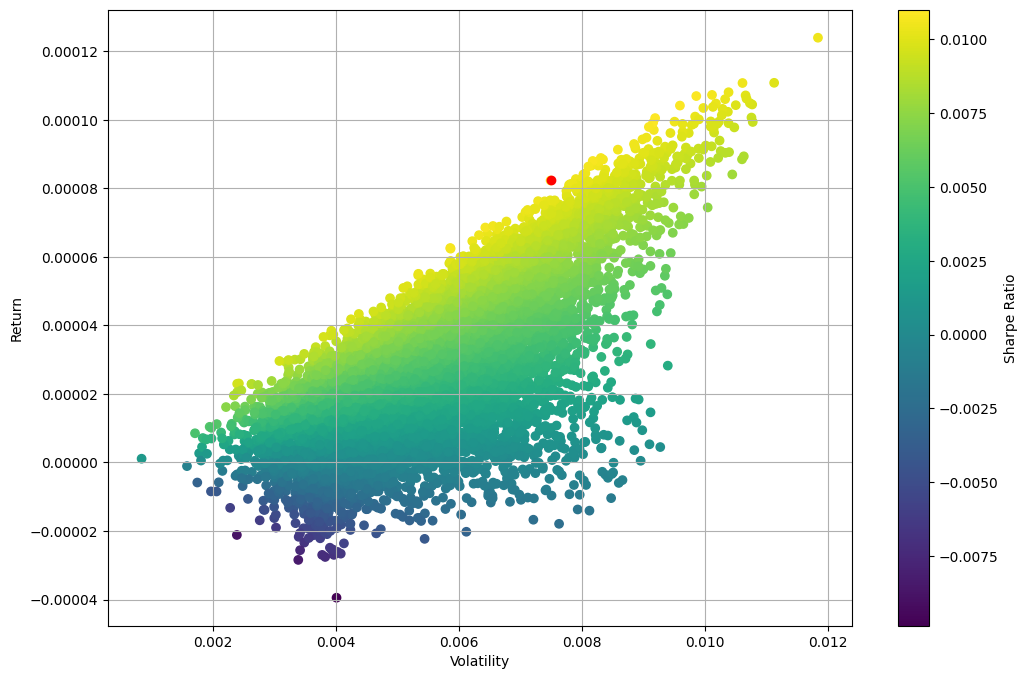

In [15]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sharpe_vol, max_sharpe_ret, c='red')
plt.grid()
plt.show()

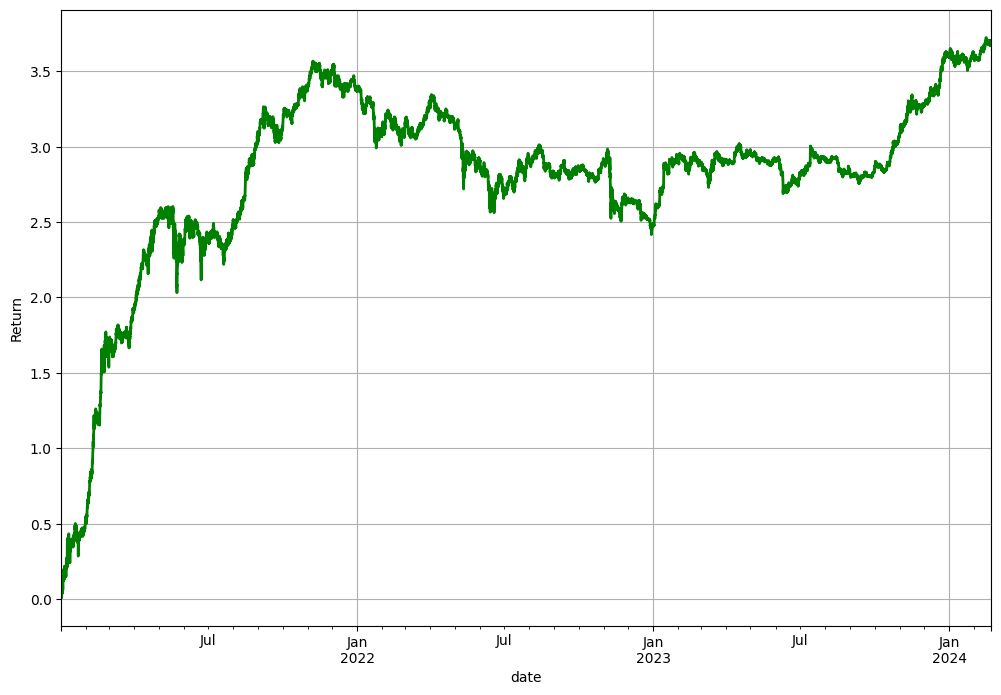

In [16]:
plt.figure(figsize=(12,8))
plt.ylabel('Return')
np.matmul(df_h_pct[selected_portfolio][:trainEND], all_portf[max_sharpe_portf, :]).cumsum().plot(color='green', linewidth=2)
plt.grid()
plt.show()

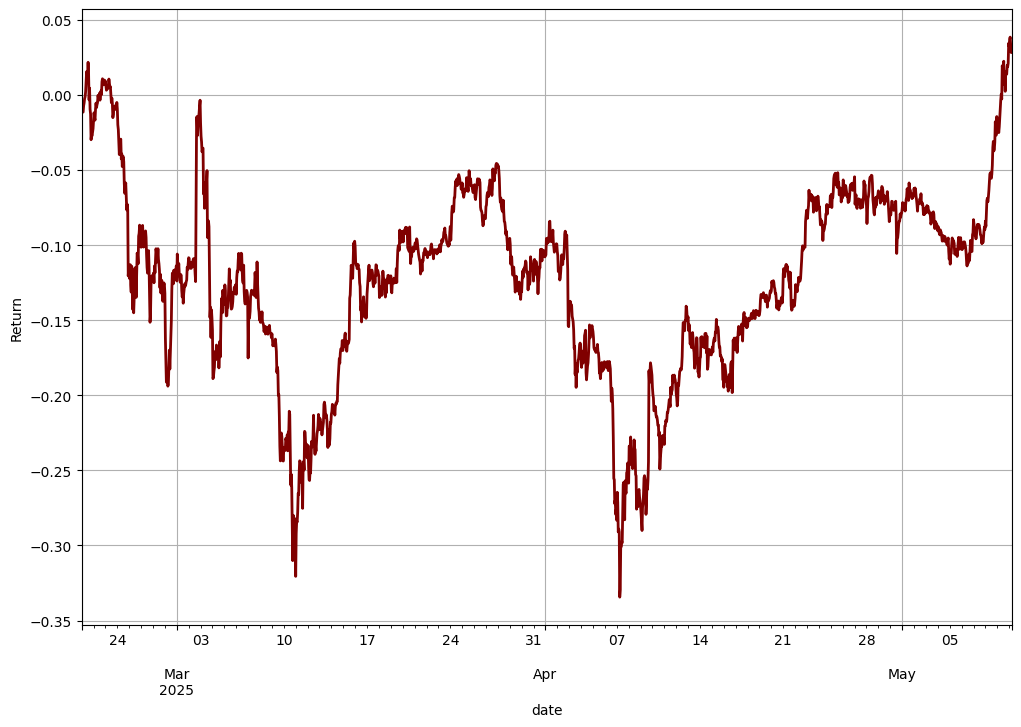

In [17]:
# бэктест
plt.figure(figsize=(12,8))
plt.ylabel('Return')
np.matmul(df_h_pct[selected_portfolio][testSTART:], all_portf[max_sharpe_portf, :]).cumsum().plot(color='maroon', linewidth=2)
plt.grid()
plt.show()

In [18]:
# доходность
period_ret = 24

In [19]:
# возвращает прибыль, волатильность и коэффициент Шарпа для любого портфеля
def get_params(portf):
    portf = np.array(portf)
    ret = np.sum(df_h_log.mean() * portf) * period_ret
    vol = np.sqrt(np.dot(portf.T, np.dot(df_h_log.cov()*period_ret, portf)))
    shrp = ret/vol
    return np.array([ret, vol, shrp])

# вовзращает отрицательный кэф. Шарпа, чтобы решать задачу минимизации
def neg_sharpe(portf):
    return get_params(portf)[2] * -1

# проверка на валидность: возвращает 0, если сумма равна 1
def check_valid(portf):
    return np.sum(portf) - 1

In [20]:
cons = ({'type': 'eq', 'fun': check_valid})
bounds = tuple([(0, 1) for _ in range(assetsNum)])
init_portf = [1/assetsNum for _ in range(assetsNum)]

In [21]:
# поиск оптимального портфеля с помощью МНК
from scipy.optimize import minimize
res = minimize(neg_sharpe, init_portf, method='SLSQP', bounds=bounds, constraints=cons)
print(res)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.04876685861243306
       x: [ 5.124e-01  4.876e-01  1.214e-17  0.000e+00  0.000e+00
            0.000e+00  0.000e+00]
     nit: 13
     jac: [ 3.793e-05 -3.985e-05  1.176e-02  8.185e-03  4.676e-02
            1.532e-02  3.808e-02]
    nfev: 104
    njev: 13


In [22]:
get_params(res.x)

array([0.00236733, 0.04854391, 0.04876686])

## Визуализация границ

In [23]:
def minimize_vol(portf):
    return get_params(portf)[1]

In [24]:
frontier_x = []
frontier_y = np.linspace(0, 0.6, 200)

for y in frontier_y:
    cons = ({'type':'eq', 'fun': check_valid},
            {'type':'eq', 'fun': lambda w: get_params(w)[0] - y})
    
    result = minimize(minimize_vol, init_portf, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

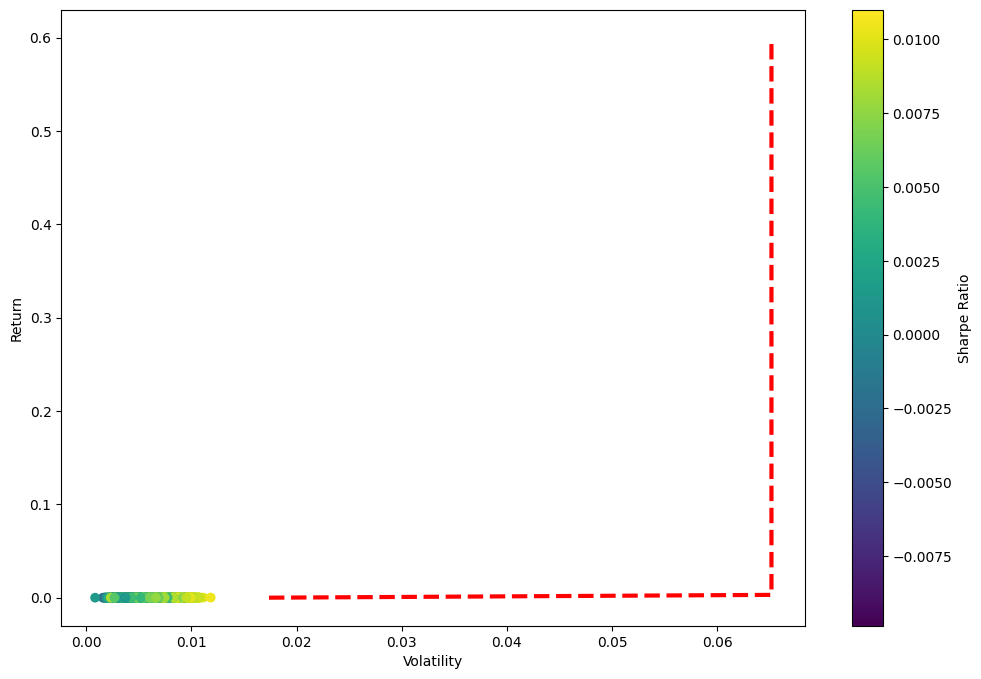

In [25]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x, frontier_y, 'r--', linewidth=3)
plt.show()

## Динамика по портфелю + тестирование

In [26]:
train_din = np.matmul(df_h_pct[selected_portfolio][:trainEND], res.x).cumsum() 
test_din = np.matmul(df_h_pct[selected_portfolio][testSTART:], res.x).cumsum() 

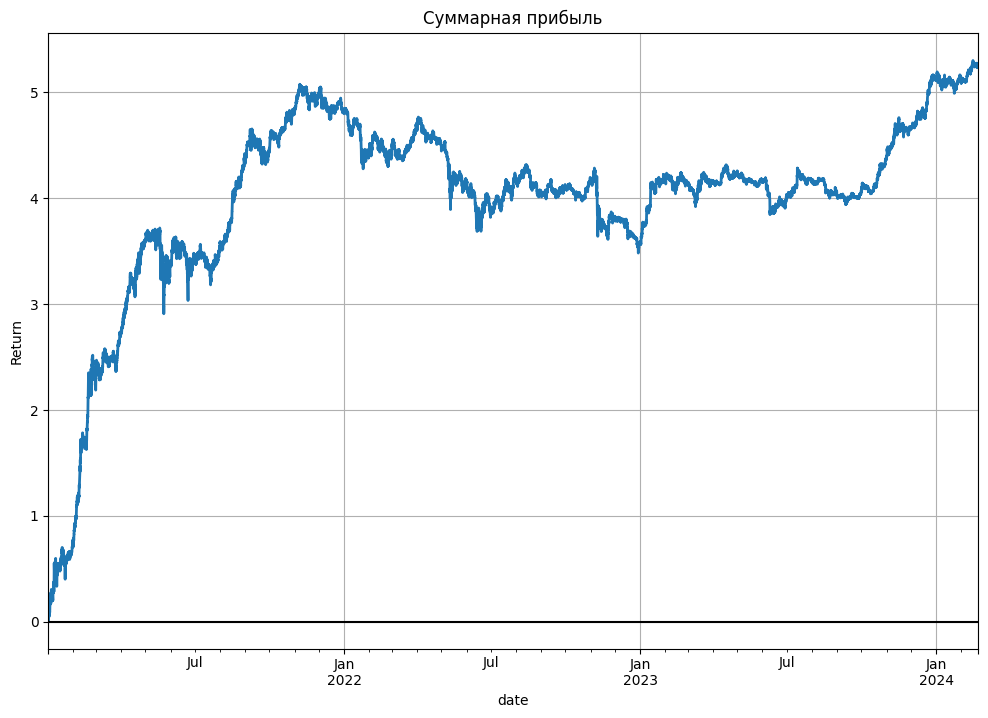

In [27]:
plt.figure(figsize=(12,8))
train_din.plot(linewidth=2)
plt.title('Суммарная прибыль')
plt.ylabel('Return')
plt.grid()
plt.axhline(y=0, color='black')
plt.show()

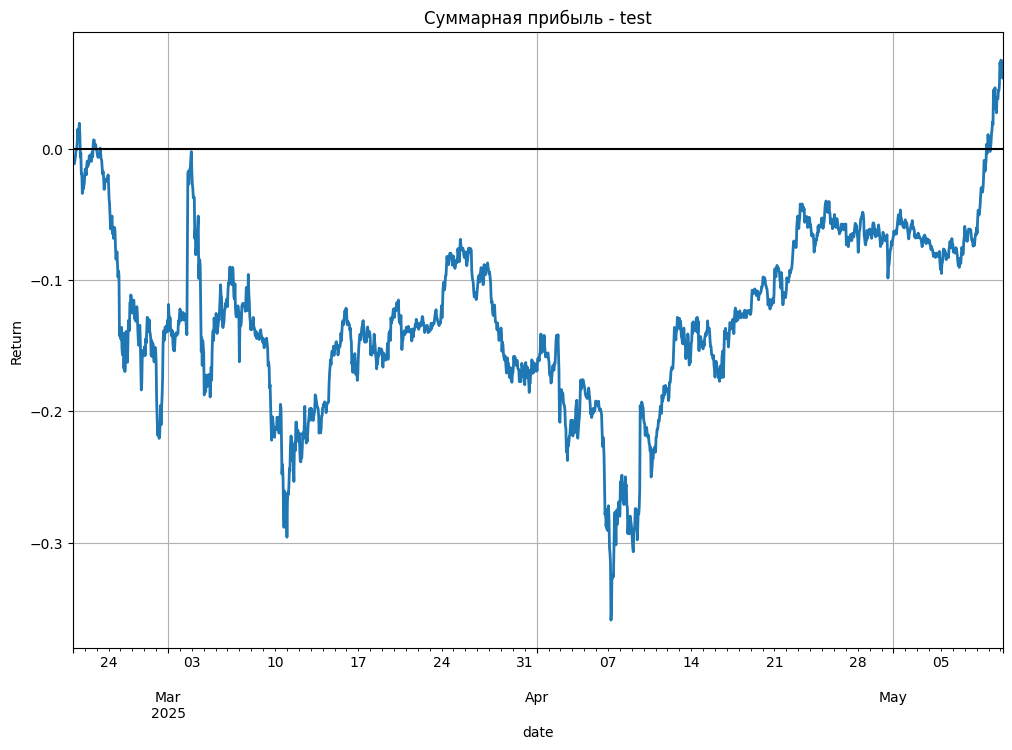

In [28]:
plt.figure(figsize=(12,8))
test_din.plot(linewidth=2)
plt.title('Суммарная прибыль - test')
plt.ylabel('Return')
plt.grid()
plt.axhline(y=0, color='black')
plt.show()

In [29]:
np.matmul(df_h_pct[selected_portfolio][testSTART:], res.x).to_csv('./markowitz_return_series.csv')

In [30]:
# Доходность портфеля за период
print('Доходность портфеля за период {:.2%}'.format(test_din[-1]))
# Шарп
print('Коэффициент Шарпа {:.2f}'.format(test_din[-1] / test_din.std()))

Доходность портфеля за период 5.37%
Коэффициент Шарпа 0.81


C:\Users\igora\AppData\Local\Temp\ipykernel_20920\3612585654.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Доходность портфеля за период {:.2%}'.format(test_din[-1]))
C:\Users\igora\AppData\Local\Temp\ipykernel_20920\3612585654.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Коэффициент Шарпа {:.2f}'.format(test_din[-1] / test_din.std()))


## Ребалансировка

In [31]:
# Сколько дней бэктеста всего
backPeriodAll = (df_h_log[selected_portfolio].index[-1] - df_h_log[selected_portfolio][testSTART:].index[0]).days

# Раз в сколько дней делать ребалансировку (раз в день)
reFreq = 7  #  ребалансировка

# Формируем все даты ребалансировки
reDates = pd.date_range(start=testSTART, end=df_h_log[selected_portfolio].index[-1], freq=f'{reFreq}D')

print(reDates)

DatetimeIndex(['2025-02-21', '2025-02-28', '2025-03-07', '2025-03-14',
               '2025-03-21', '2025-03-28', '2025-04-04', '2025-04-11',
               '2025-04-18', '2025-04-25', '2025-05-02', '2025-05-09'],
              dtype='datetime64[ns]', freq='7D')


In [32]:
import numpy as np
import pandas as pd

# Параметры
period_ret = 24 * 30 * 3
iterNum = 5000    # Количество случайных портфелей
assetsNum = len(df[selected_portfolio].columns)  # Количество активов
reWindow = 30 * 12      # Окно обучения для ребалансировки (в днях) 560
rePortfs = {}     # Словарь для хранения оптимальных портфелей

# Генерация случайных портфелей для каждой даты ребалансировки
for d in range(len(reDates)):
    # Определяем окно обучения для текущей даты ребалансировки
    start_date = reDates[d] - pd.Timedelta(days=reWindow)  # Начало окна
    end_date = reDates[d]  # Конец окна
    retrain_df = df_h_log[selected_portfolio].loc[start_date:end_date]  # Данные за окно

    all_portf = np.zeros((iterNum, assetsNum))  # Все портфели
    ret_arr = np.zeros(iterNum)  # Доходность
    vol_arr = np.zeros(iterNum)  # Волатильность
    sharpe_arr = np.zeros(iterNum)  # Коэффициент Шарпа

    for x in range(iterNum):
        # Генерация случайных весов портфеля
        portf = np.random.random(assetsNum)
        portf = portf / np.sum(portf)  # Нормализация весов до суммы = 1
        
        all_portf[x, :] = portf  # Сохраняем веса
        
        # Расчет доходности
        ret_arr[x] = np.sum((retrain_df[selected_portfolio].mean() * portf) * period_ret)
        
        # Расчет волатильности
        vol_arr[x] = np.sqrt(np.dot(portf.T, np.dot(retrain_df[selected_portfolio].cov() * period_ret, portf)))
        
        # Расчет коэффициента Шарпа
        sharpe_arr[x] = ret_arr[x] / vol_arr[x]
    
    # Находим портфель с максимальным коэффициентом Шарпа
    max_sharpe_idx = sharpe_arr.argmax()
    max_sharpe_portf = all_portf[max_sharpe_idx, :]
    max_sharpe_ret = ret_arr[max_sharpe_idx]
    max_sharpe_vol = vol_arr[max_sharpe_idx]

    # Сохраняем оптимальный портфель для текущей даты ребалансировки
    rePortfs[reDates[d]] = list(max_sharpe_portf)

    # Выводим информацию о текущей итерации
    print(f"Дата ребалансировки: {reDates[d]}")
    print(f"Максимальный коэффициент Шарпа: {sharpe_arr.max():.4f}")
    print(f"Оптимальные веса: {max_sharpe_portf}")
    print("=" * 30)

Дата ребалансировки: 2025-02-21 00:00:00
Максимальный коэффициент Шарпа: 0.3995
Оптимальные веса: [0.19014484 0.23260736 0.02441574 0.301007   0.00441594 0.01344735
 0.23396179]
Дата ребалансировки: 2025-02-28 00:00:00
Максимальный коэффициент Шарпа: 0.1782
Оптимальные веса: [0.32188205 0.00479907 0.0770133  0.04420381 0.00109729 0.11409561
 0.43690887]
Дата ребалансировки: 2025-03-07 00:00:00
Максимальный коэффициент Шарпа: 0.0044
Оптимальные веса: [0.28130882 0.05890266 0.00306032 0.35515801 0.01109782 0.1333193
 0.15715307]
Дата ребалансировки: 2025-03-14 00:00:00
Максимальный коэффициент Шарпа: -0.0442
Оптимальные веса: [0.06563538 0.01729345 0.03283477 0.42241299 0.0376657  0.02177327
 0.40238445]
Дата ребалансировки: 2025-03-21 00:00:00
Максимальный коэффициент Шарпа: 0.0393
Оптимальные веса: [0.25777829 0.04020708 0.07531026 0.59908473 0.00926015 0.01372827
 0.00463122]
Дата ребалансировки: 2025-03-28 00:00:00
Максимальный коэффициент Шарпа: -0.0315
Оптимальные веса: [0.34911537

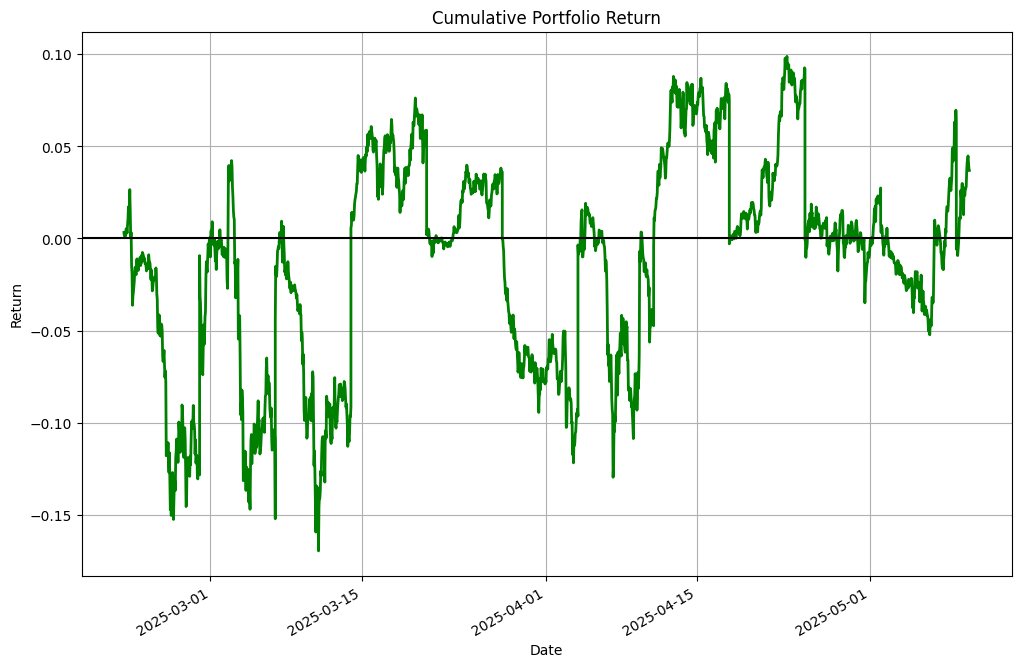

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Визуализация на процентной доходности
retest_din = None  # Инициализируем переменную для хранения результатов

for d in range(len(reDates)):
    # Определяем временной интервал для текущего периода тестирования
    start_date = reDates[d]
    if d < len(reDates) - 1:
        end_date = reDates[d + 1]
    else:
        end_date = None  # Если это последний период, берем данные до конца
    
    # Берем данные за текущий период
    retest_df = df_h_pct[selected_portfolio].loc[start_date:end_date]
    
    # Вычисляем доходность портфеля с учетом оптимальных весов
    portfolio_return = np.matmul(retest_df, rePortfs[reDates[d]])
    
    # Накопленная доходность (cumsum)
    cumulative_return = pd.Series(portfolio_return).cumsum()
    
    # Объединяем данные
    if retest_din is None:
        retest_din = cumulative_return
    else:
        retest_din = pd.concat([retest_din, cumulative_return])

# Визуализация
plt.figure(figsize=(12, 8))
retest_din.plot(color='green', linewidth=2)
plt.title('Cumulative Portfolio Return')
plt.ylabel('Return')
plt.xlabel('Date')
plt.grid()
plt.axhline(y=0, color='black')  # Горизонтальная линия на уровне 0
plt.show()

In [34]:
# Доходность портфеля за период
print('Доходность портфеля за период {:.2%}'.format(retest_din[-1]))
# Шарп
print('Коэффициент Шарпа {:.2f}'.format(retest_din[-1] / retest_din.std()))

Доходность портфеля за период 3.69%
Коэффициент Шарпа 0.65


C:\Users\igora\AppData\Local\Temp\ipykernel_20920\3689587041.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Доходность портфеля за период {:.2%}'.format(retest_din[-1]))
C:\Users\igora\AppData\Local\Temp\ipykernel_20920\3689587041.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Коэффициент Шарпа {:.2f}'.format(retest_din[-1] / retest_din.std()))


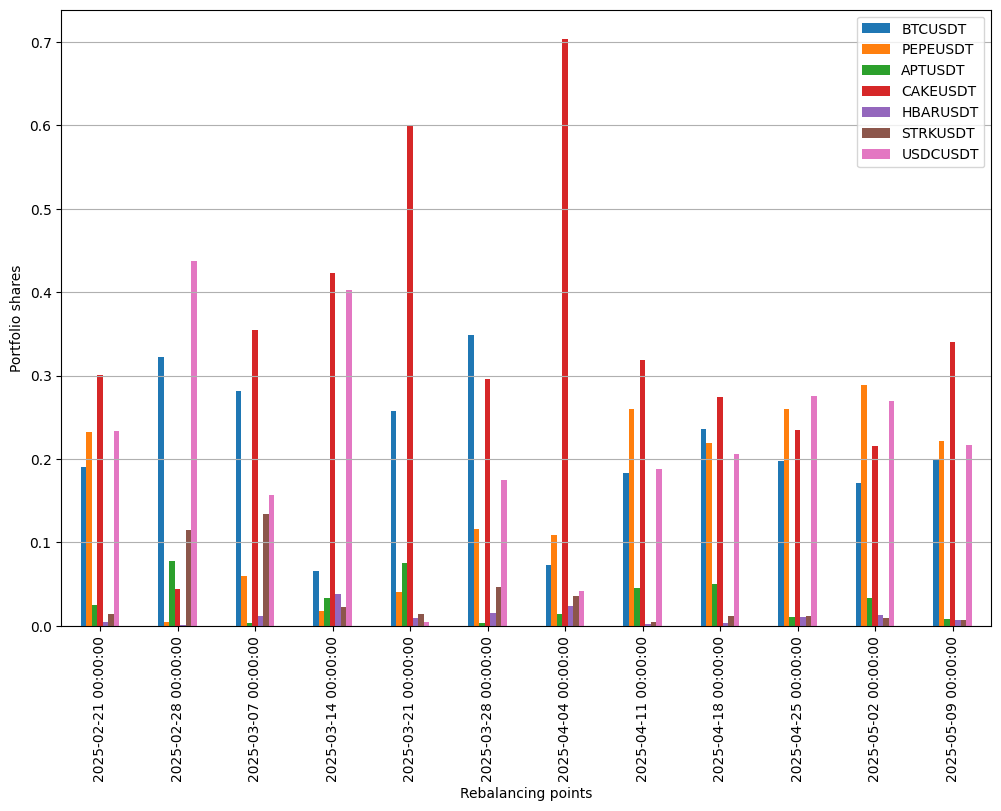

In [35]:
pd.DataFrame(rePortfs).T.plot(kind='bar', figsize=(12,8))
plt.legend(selected_portfolio)
plt.grid(axis='y')
plt.ylabel('Portfolio shares')
plt.xlabel('Rebalancing points')
plt.show()

In [36]:
rePortfs

{Timestamp('2025-02-21 00:00:00'): [np.float64(0.1901448355476975),
  np.float64(0.23260735655121045),
  np.float64(0.024415736999823127),
  np.float64(0.30100699549156773),
  np.float64(0.0044159354933804105),
  np.float64(0.013447353161691699),
  np.float64(0.23396178675462906)],
 Timestamp('2025-02-28 00:00:00'): [np.float64(0.3218820523655558),
  np.float64(0.004799067732179582),
  np.float64(0.07701330043409246),
  np.float64(0.04420381319465294),
  np.float64(0.0010972850253940566),
  np.float64(0.11409560682112474),
  np.float64(0.4369088744270003)],
 Timestamp('2025-03-07 00:00:00'): [np.float64(0.2813088160628324),
  np.float64(0.05890266011568034),
  np.float64(0.0030603204430851533),
  np.float64(0.35515800675135645),
  np.float64(0.011097819963798118),
  np.float64(0.13331930349606091),
  np.float64(0.1571530731671867)],
 Timestamp('2025-03-14 00:00:00'): [np.float64(0.0656353774349805),
  np.float64(0.017293447994322746),
  np.float64(0.03283476525978105),
  np.float64(0.4

In [37]:
import os
import pandas as pd

# Конфигурация
DATA_DIR = "../data"
MODELS_PREDICTION_DIR = os.path.join(DATA_DIR, "models_predictions")
os.makedirs(MODELS_PREDICTION_DIR, exist_ok=True)


# Преобразование данных в DataFrame
df = pd.DataFrame.from_dict(rePortfs, orient='index', columns=["APTUSDT", "CAKEUSDT", "HBARUSDT", "JUPUSDT", "PEPEUSDT", "STRKUSDT", "USDCUSDT"])
df.index.name = "date"

# Сохранение в CSV
output_file = os.path.join(MODELS_PREDICTION_DIR, "model_markowitz_actions.csv")
df.to_csv(output_file)

print(f"Файл успешно сохранен: {output_file}")

Файл успешно сохранен: ../data\models_predictions\model_markowitz_actions.csv
